In [1]:
!pip install tensorflow

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten

In [34]:
# 데이터 불러오기
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)


In [35]:
# 정규화
scaler = MinMaxScaler()
data = scaler.fit_transform(df[['y']])


In [36]:
# 시퀀스 생성 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [37]:
SEQ_LEN = 12  # 12개월 사용해서 다음 달 예측
X, y = create_sequences(data, SEQ_LEN)

In [38]:
# 학습 / 테스트 분리
split = len(X) - 12
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [39]:
# LSTM
model_LSTM = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, 1)),
    Dense(1)
])

# CNN 모델 구성
model_CNN = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SEQ_LEN, 1)),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
model_CNN.compile(optimizer='adam', loss='mse')
model_CNN.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)


In [44]:
# 예측 및 복원
pred = model_CNN.predict(X_test)
pred = scaler.inverse_transform(pred)
y_test_true = scaler.inverse_transform(y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


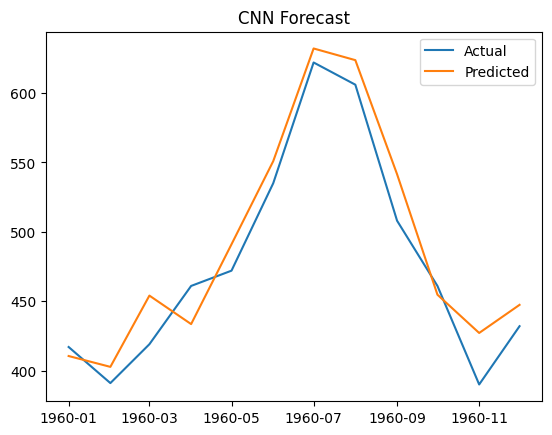

In [45]:
# 시각화
test_index = df.index[-len(y_test):]
plt.plot(test_index, y_test_true, label='Actual')
plt.plot(test_index, pred, label='Predicted')
plt.legend()
plt.title("CNN Forecast")
plt.show()

In [43]:
# RMSE 출력
rmse = np.sqrt(mean_squared_error(y_test_true, pred))
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 355.62


트랜스포머는 CNN, LSTM에 비해 훨씬 많은 양의 데이터를 필요로 함
또한 복잡한 feature 간ㅇㅇ